# CanESM5 GMD paper Figure 21
## Ocean biogeochemistry sections

### history
- NCS, setup basic example, 2019-04-11

In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import brewer2mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import iris
import iris.analysis.cartography
import modules.basic_stats as bst
import modules.plotting_module as pltm
import sqlite3
from cdo import *

cdo = Cdo()
cdo.setCdo('/home/ords/crd/ccrn/scrd104/miniconda3/bin/cdo')

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
%store -r start 
%store -r end
%store -r title_fontsize

In [3]:
### Pre-process the data using cdo
#Basically time-merge the files split over decades, compute the time mean, and then remap to the WOA09/GLODAPv2 grid
# Look at `cdo` remapping to the WOA09 grid horizontall, and vertically interpolating to the WOA09 depths.
# This uses the cdo python bindings, but it identical to doing it on the command line.

regrid=False

if regrid:
    thetao_obs = xr.open_dataset('input_data/obs/woa/woa09/uncs_woa09_ann_tpot.nc', decode_times=False)['tpot']
    woa09_depths = [str(f) for f in thetao_obs.depth.values]
    
    # Join and remap these for a list of variables - CanESM5
    datapath='input_data/CanESM5_cmip_dir/historical/r1i1p1f1/Omon/{var}/gn/v20190429/'
    filelist=['{var}_Omon_CanESM5_historical_r1i1p1f1_gn_198101-199012.nc', 
              '{var}_Omon_CanESM5_historical_r1i1p1f1_gn_199101-200012.nc', 
              '{var}_Omon_CanESM5_historical_r1i1p1f1_gn_200101-201012.nc'
             ]
    
    varlist=['dissic', 'no3', 'o2']
            
    for var in varlist:
        filestr=' '.join([datapath.format(var=var) + f.format(var=var) for f in filelist])
        cdo.intlevelx(','.join(woa09_depths), 
                     input='-remapbil,obs/woa/woa09/uncs_woa09_ann_tpot.nc -timmean -mergetime ' + filestr, 
                     output='input_data/processed_data/remap_vertint-woa09_' + var +  '_Omon_CanESM5_historical_r1i1p1f1_gn_198101-201012.nc', options='-L')   
        cdo.intlevelx(','.join(woa09_depths), 
                     input='-remapbil,obs/woa/woa09/uncs_woa09_ann_tpot.nc -mergetime ' + filestr, 
                     output='input_data/processed_data/remap_vertint-woa09_' + var +  '_Omon_CanESM5_historical_r1i1p1f1_gn_198101-201012_monmeans.nc', options='-L')
        
    # Join and remap these for a list of variables - CanESM2
    datapath='input_data/CanESM2_large_ensemble/historical-r1/yr/ocnBgchem/{var}/r1i1p1/'
    f = '{var}_Oyr_CanESM2_historical-r1_r1i1p1_1950-2020.nc'

    varlist=['dissic', 'no3'] #no o2 in CanESM2

    for var in varlist:
        filestr=' '.join([datapath.format(var=var) + f.format(var=var)])
        cdo.intlevelx(','.join(woa09_depths), 
                     input='-remapbil,obs/woa/woa09/uncs_woa09_ann_tpot.nc -timmean -mergetime ' + filestr, 
                     output='input_data/processed_data/remap_vertint-woa09_' + var +  '_Oyr_CanESM2_historical-r1_r1i1p1_1950-2020.nc', options='-L')    
        cdo.intlevelx(','.join(woa09_depths), 
                     input='-remapbil,obs/woa/woa09/uncs_woa09_ann_tpot.nc ' + filestr, 
                     output='input_data/processed_data/remap_vertint-woa09_' + var +  '_Oyr_CanESM2_historical-r1_r1i1p1_1950-2020_annmeans.nc', options='-L')    

In [4]:
#open timemean data
mask = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_dissic_Omon_CanESM5_historical_r1i1p1f1_gn_198101-201012.nc')['dissic']
mask2 = mask[0,...].sel(lev=10).where( (mask.lat>40) & (mask.lat<47) & (mask.lon>25) & (mask.lon<45))

dissic = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_dissic_Omon_CanESM5_historical_r1i1p1f1_gn_198101-201012.nc')['dissic'].squeeze()*1e6/1035#.where( np.isnan(mask2), np.nan)
no3 = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_no3_Omon_CanESM5_historical_r1i1p1f1_gn_198101-201012.nc')['no3'].squeeze()*1e6/1035#.where( np.isnan(mask2), np.nan)
o2 = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_o2_Omon_CanESM5_historical_r1i1p1f1_gn_198101-201012.nc')['o2'].squeeze()*1e6/1035#.where( np.isnan(mask2), np.nan)

dissic_CanESM2 = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_dissic_Oyr_CanESM2_historical-r1_r1i1p1_1950-2020.nc')['dissic'].squeeze()*1e6/1035#.where( np.isnan(mask2), np.nan)
no3_CanESM2 = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_no3_Oyr_CanESM2_historical-r1_r1i1p1_1950-2020.nc')['no3'].squeeze()*1e6/1035#.where( np.isnan(mask2), np.nan)

dissic_obs = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_reformatted_GLODAPv2.2016b.TCO2.nc', decode_times=False)['TCO2'].rename( {'depth':'lev'}).squeeze()#.where( np.isnan(mask2), np.nan)
no3_obs=xr.open_dataset('input_data/processed_data/remap_vertint-woa09_reformatted_GLODAPv2.2016b.NO3.nc')['NO3'].rename( {'depth':'lev'}).squeeze()#.where( np.isnan(mask2), np.nan)
o2_obs=xr.open_dataset('input_data/processed_data/remap_vertint-woa09_reformatted_GLODAPv2.2016b.oxygen.nc')['oxygen'].rename( {'depth':'lev'}).squeeze()#.where( np.isnan(mask2), np.nan)

In [5]:
#get zonal means
dissic_zm = dissic.mean(dim=['lon'])
dissic_obs_zm = dissic_obs.mean(dim='lon')
no3_zm = no3.mean(dim=['lon'])
no3_obs_zm = no3_obs.mean(dim='lon')
o2_zm = o2.mean(dim=['lon'])
o2_obs_zm = o2_obs.mean(dim='lon')

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


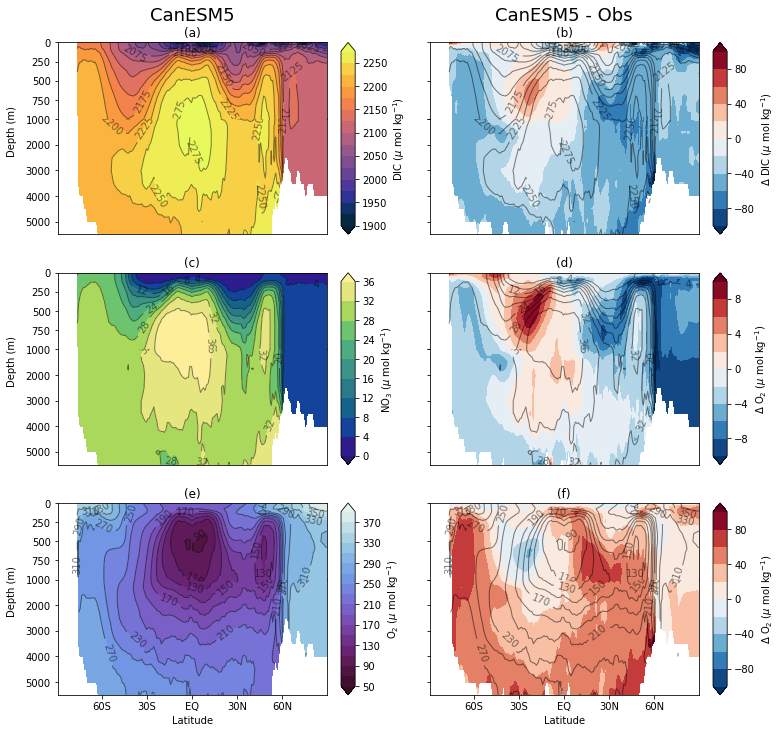

In [6]:
#plotting
fig = plt.figure(figsize=(12, 12), constrained_layout=False)
outer_grid = fig.add_gridspec(3, 2, wspace=0.25, hspace=0.2)


# plot the dissic
axt, axm, axc = pltm.inner_gs_vardepth(outer_grid[0], labely=True, labelx=False)
cmap=cmocean.cm.thermal
cmap.set_bad(cfeature.COLORS['land'])
levelsd = np.arange(1900,2300,25)
for ax in [axt, axm]:
    cb  = ax.contourf(dissic.lat, dissic.lev, dissic_zm, cmap=cmap, levels=levelsd,extend='both')
    cntr = ax.contour(dissic.lat, dissic.lev, dissic_zm, levels=levelsd, colors='k', linewidths=1, alpha=0.5)
    ax.clabel(cntr,fmt='%1.0f')
plt.colorbar(cb, cax=axc, extend='both', label =r'DIC ($\mu$ mol kg$^{-1}$)')
axt.set_title('(a)')
axt.text(0.5, 1.35, 'CanESM5', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize, transform=axt.transAxes)
 
    
# plot the no3
axt, axm, axc = pltm.inner_gs_vardepth(outer_grid[2], labely=True, labelx=False)
cmap=cmocean.cm.haline
cmap.set_bad(cfeature.COLORS['land'])
levelsn = np.arange(0,40,4)
for ax in [axt, axm]:
    cb  = ax.contourf(no3.lat, no3.lev, no3_zm, cmap=cmap, levels=levelsn, extend='both')
    cntr = ax.contour(no3.lat, no3.lev, no3_zm, levels=levelsn, colors='k', linewidths=1, alpha=0.5)
    ax.clabel(cntr,fmt='%1.0f')
plt.colorbar(cb, cax=axc, extend='both', label=r'NO$_3$ ($\mu$ mol kg$^{-1}$)')
axt.set_title('(c)')

# plot the o2
axt, axm, axc = pltm.inner_gs_vardepth(outer_grid[4], labely=True, labelx=True)
cmap=cmocean.cm.dense_r
cmap.set_bad(cfeature.COLORS['land'])
levelso = np.arange(50,400,20)
for ax in [axt, axm]:
    cb  = ax.contourf(o2.lat, o2.lev, o2_zm, cmap=cmap, levels=levelso, extend='both')
    cntr = ax.contour(o2.lat, o2.lev, o2_zm, levels=levelso, colors='k', linewidths=1, alpha=0.5)
    ax.clabel(cntr,fmt='%1.0f')
plt.colorbar(cb, cax=axc, extend='both', label=r'O$_2$ ($\mu$ mol kg$^{-1}$)')
axt.set_title('(e)')


# plot the dissic Anomaly
cmap=plt.cm.RdBu_r
cmap.set_bad(cfeature.COLORS['land'])
axt, axm, axc = pltm.inner_gs_vardepth(outer_grid[1], labely=False)
levels = np.arange(-100,101,20)
for ax in [axt, axm]:
    cb  = ax.contourf(dissic.lat, dissic.lev, dissic_zm - dissic_obs_zm, cmap=cmap, levels=levels,extend='both')
    cntr = ax.contour(dissic.lat, dissic.lev, dissic_zm, levels=levelsd, colors='k', linewidths=1, alpha=0.5)
    ax.clabel(cntr,fmt='%1.0f')
plt.colorbar(cb, cax=axc, extend='both', label =r'$\Delta$ DIC ($\mu$ mol kg$^{-1}$)')
axt.set_title('(b)')
axt.text(0.5, 1.35, 'CanESM5 - Obs', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize, transform=axt.transAxes)


# plot the no3 Anomaly
axt, axm, axc = pltm.inner_gs_vardepth(outer_grid[3], labely=False, labelx=False)
levels = np.arange(-10,11,2)
for ax in [axt, axm]:
    cb  = ax.contourf(no3.lat, no3.lev, no3_zm - no3_obs_zm, cmap=cmap, levels=levels, extend='both')
    cntr = ax.contour(no3.lat, no3.lev, no3_zm, levels=levelsn, colors='k', linewidths=1, alpha=0.5)
    ax.clabel(cntr,fmt='%1.0f')
plt.colorbar(cb, cax=axc, extend='both', label=r'$\Delta$ O$_2$ ($\mu$ mol kg$^{-1}$)')
axt.set_title('(d)')

# plot the o2 Anomaly
axt, axm, axc = pltm.inner_gs_vardepth(outer_grid[5], labely=False, labelx=True)
levels = np.arange(-100,101,20)
for ax in [axt, axm]:
    cb  = ax.contourf(o2.lat, o2.lev, o2_zm - o2_obs_zm, cmap=cmap, levels=levels, extend='both')
    cntr = ax.contour(o2.lat, o2.lev, o2_zm, levels=levelso, colors='k', linewidths=1, alpha=0.5)
    ax.clabel(cntr,fmt='%1.0f')
plt.colorbar(cb, cax=axc, extend='both', label=r'$\Delta$ O$_2$ ($\mu$ mol kg$^{-1}$)')
axt.set_title('(f)')

fig.savefig('plots/fig-21_ocean_bgc-sec.png', bbox_inches='tight')
fig.savefig('plots/fig-21_ocean_bgc-sec.pdf', bbox_inches='tight')

In [ ]:
##### statistics - for zonal means
xyzt = 'FTTF'
av_dims = ['time','lon'] #dimensions over which to average (time for global time means, time and lon for zonal means and sections, )
weight = np.tile(dissic_zm.lev,(180,1)).transpose()
calc_skill_score = False

#the following lists will be zipped for the stats calcs, so all info should be entered accordingly
model_names    = ['CanESM5','CanESM5','CanESM5']  
model_datasets    = [dissic_zm,no3_zm,o2_zm]
model_fulldatasets = [None,None,None]

obs_names    = ['woa09','woa09','woa09']
obs_datasets    = [dissic_obs_zm,no3_obs_zm,o2_obs_zm]
obs_fulldatasets = [None,None,None]

stats_names = ['dissic_zonal_timemean','no3_zonal_timemean', 'o2_zonal_timemean'] #names for json file
varslist = ['dissic','no3','o2']


bst.calc_stats_and_write(obs_datasets, obs_fulldatasets, obs_names, model_datasets, model_fulldatasets, model_names, stats_names, varslist, weight, xyzt, av_dims, start, end, calc_skill_score=calc_skill_score)

In [7]:
#open timeseries data - for calculating skill scores on full 3d data

dissic_monmeans = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_dissic_Omon_CanESM5_historical_r1i1p1f1_gn_198101-201012_monmeans.nc')['dissic'].squeeze()*1e6/1035#.where( np.isnan(mask2), np.nan)
no3_monmeans = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_no3_Omon_CanESM5_historical_r1i1p1f1_gn_198101-201012_monmeans.nc')['no3'].squeeze()*1e6/1035#.where( np.isnan(mask2), np.nan)
o2_monmeans = xr.open_dataset('input_data/processed_data/remap_vertint-woa09_o2_Omon_CanESM5_historical_r1i1p1f1_gn_198101-201012_monmeans.nc')['o2'].squeeze()*1e6/1035#.where( np.isnan(mask2), np.nan)


In [ ]:
##### statistics - for full 3D timemeans

#weights
levs = dissic.lev.diff('lev',n=1).values
levs = np.insert(levs, 0, 10, axis=0)
lev_weights = np.tile(np.tile(levs,(180,1)),(360,1,1))

gridcellareas =  xr.open_dataset('input_data/obs/woa/woa09_gridarea.nc')['cell_area'].values
gridcellaarea_weights = np.tile(gridcellareas,(len(levs),1,1))
gridcellaarea_weights_t = gridcellaarea_weights.transpose()

gridvolume_weights = lev_weights*gridcellaarea_weights_t


xyzt = 'TTTF'
av_dims = ['time'] #dimensions over which to average (time for global time means, time and lon for zonal means and sections)
weight = gridvolume_weights
calc_skill_score = False

#the following lists will be zipped for the stats calcs, so all info should be entered accordingly
model_names    = ['CanESM5','CanESM5','CanESM5']
model_datasets    = [dissic,no3,o2]
model_fulldatasets = [dissic_monmeans,no3_monmeans,o2_monmeans]
 
obs_names    = ['woa09','woa09','woa09']
obs_datasets    = [dissic_obs,no3_obs,o2_obs]
obs_fulldatasets = [None,None,None]

stats_names = ['dissic_3D_timemean','no3_3D_timemean', 'o2_3D_timemean'] #names for json file
varslist = ['dissic','no3','o2',]


bst.calc_stats_and_write(obs_datasets, obs_fulldatasets, obs_names, model_datasets, model_fulldatasets, model_names, stats_names, varslist, weight, xyzt, av_dims, 
                         start, end, calc_skill_score=calc_skill_score, use_model_std=True, annual_data=False)